In [10]:
%pip install pandas numpy scikit seaborn matplotlib statsmodels scipy seaborn prophet 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scikit (from versions: none)
ERROR: No matching distribution found for scikit


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv('ARIMA.csv')

In [13]:
nsw_data = df[df['Suburb'] == 'Albany']

# Convert 'Month' to datetime format and ensure 'Sales' is numeric
nsw_data['Month'] = pd.to_datetime(nsw_data['Month'], format='%m/%d/%Y')
nsw_data['Sales'] = pd.to_numeric(nsw_data['Sales'], errors='coerce')

# Aggregate sales by month
nsw_monthly_sales = nsw_data.groupby(pd.Grouper(key='Month', freq='M'))['Sales'].sum().reset_index()

# Rename columns as required by Prophet
nsw_monthly_sales.rename(columns={'Month': 'ds', 'Sales': 'y'}, inplace=True)

nsw_monthly_sales.head()

C:\Users\Ilzam\AppData\Local\Temp\ipykernel_49212\2377648505.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_data['Month'] = pd.to_datetime(nsw_data['Month'], format='%m/%d/%Y')
C:\Users\Ilzam\AppData\Local\Temp\ipykernel_49212\2377648505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_data['Sales'] = pd.to_numeric(nsw_data['Sales'], errors='coerce')


,ds,y
0,2016-01-31,8497.10
1,2016-02-29,11124.59
2,2016-03-31,8880.79
3,2016-04-30,12853.84
4,2016-05-31,10245.43


In [14]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [15]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In [16]:
from statsmodels.tsa.stattools import adfuller

adf_test(nsw_monthly_sales['y'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.740357
p-value                         0.410449
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


In our above example, the test statistic > critical value, which implies that the series is not stationary. This confirms our original observation which we initially saw in the visual test.

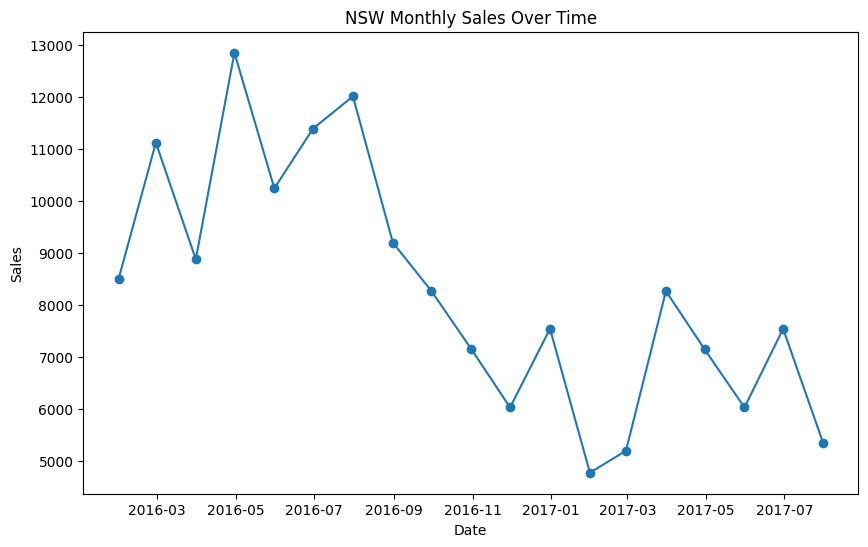

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(nsw_monthly_sales['ds'], nsw_monthly_sales['y'], marker='o', linestyle='-')
plt.title('NSW Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [21]:
# Differencing the data to make it stationary
nsw_monthly_sales_diff = nsw_monthly_sales['y'].diff().dropna()

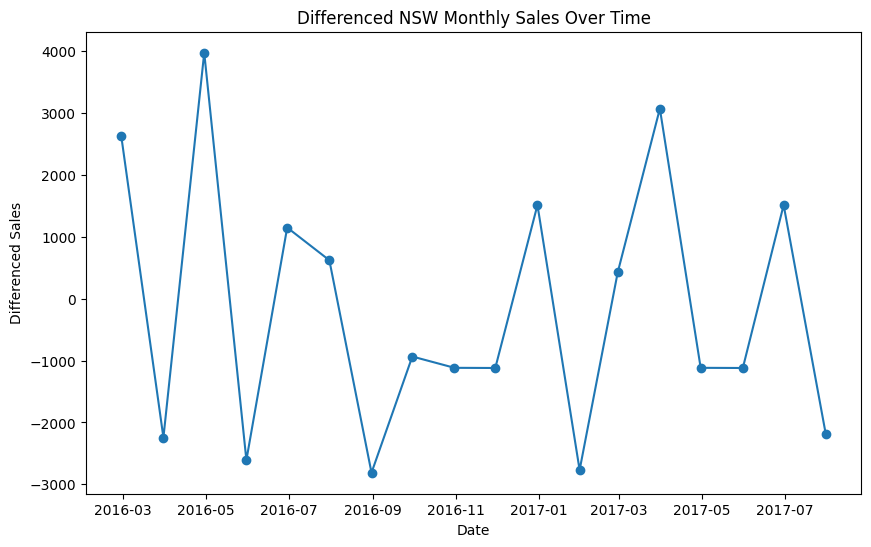

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(nsw_monthly_sales['ds'][1:], nsw_monthly_sales_diff, marker='o', linestyle='-')
plt.title('Differenced NSW Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.show()

In [23]:
# Redo the ADF test on differenced data to check for stationarity
adf_test(nsw_monthly_sales_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -1.791748
p-value                         0.384566
#Lags Used                      7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


In [25]:
%pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 1.3 MB/s eta 0:00:11
    --------------------------------------- 0.2/13.3 MB 1.6 MB/s eta 0:00:09
   - -------------------------------------- 0.4/13.3 MB 1.9 MB/s eta 0:00:08
   - -------------------------------------- 0.4/13.3 MB 1.9 MB/s eta 0:00:07
   - -------------------------------------- 0.4/13.3 MB 1.9 MB/s eta 0:00:07
   - -------------------------------------- 0.4/13.3 MB 1.9 MB/s eta 0:00:07
   - -------------------------------------- 0.4/13.3 MB 1.1 MB/s eta 0:00:12
   - -------------------------------------- 0.5/13.3 MB 1.2 MB/s eta 0:00:12
   - -------------------------------------- 0.6/13.3 MB 1.3 MB/s eta 0:00:11
   -- ------------------------------------- 0.7/13.3 MB 1.3 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/13.3 MB 1.4 MB/s eta 0:00:10
   -- -------

In [27]:
from prophet import Prophet

In [28]:
model = Prophet()
model.fit(nsw_monthly_sales)

13:42:56 - cmdstanpy - INFO - Chain [1] start processing
13:42:57 - cmdstanpy - INFO - Chain [1] done processing


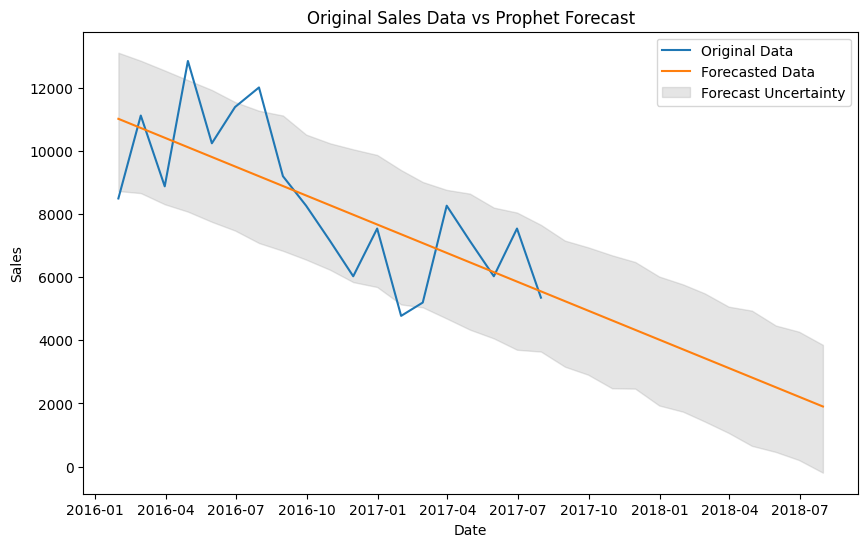

In [30]:
future_dates = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future_dates)

# Plotting the original data
plt.figure(figsize=(10, 6))
plt.plot(nsw_monthly_sales['ds'], nsw_monthly_sales['y'], label='Original Data')

# Plotting the forecasted data
# Note: Prophet forecasts include the original dates, so we can plot it directly against the original data
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Data')

# Highlighting the forecasted period
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Forecast Uncertainty')

plt.title('Original Sales Data vs Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()